In [6]:
# ============================================================
# 🧭 Step 1 — Data Import for Pitch/Roll Free Decay (Auto Axis)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === Base directory ===
base_path = Path(
    r"C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\roll"
)


# === Auto-detect AXIS from folder name ===
folder_name = base_path.name.lower()
if "roll" in folder_name:
    AXIS = "roll"
elif "pitch" in folder_name:
    AXIS = "pitch"
else:
    raise ValueError("Cannot detect axis from folder name (expected 'roll' or 'pitch').")

# === Collect all *_m.csv datasets ===
datasets = {}
for file in base_path.glob("*_m.csv"):
    try:
        df = pd.read_csv(file)
    except Exception as e:
        print(f"⚠️ Could not read {file.name}: {e}")
        continue

    if "time_s" not in df.columns:
        print(f"⚠️ Skipping {file.name}: no 'time_s' column.")
        continue

    df["t"] = df["time_s"] - df["time_s"].iloc[0]
    datasets[file.stem] = df

if not datasets:
    raise FileNotFoundError(f"No *_m.csv datasets found in {base_path}")

print(f"✅ Loaded {len(datasets)} dataset(s) for {AXIS.upper()} analysis from:\n→ {base_path}")


✅ Loaded 8 dataset(s) for ROLL analysis from:
→ C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\roll


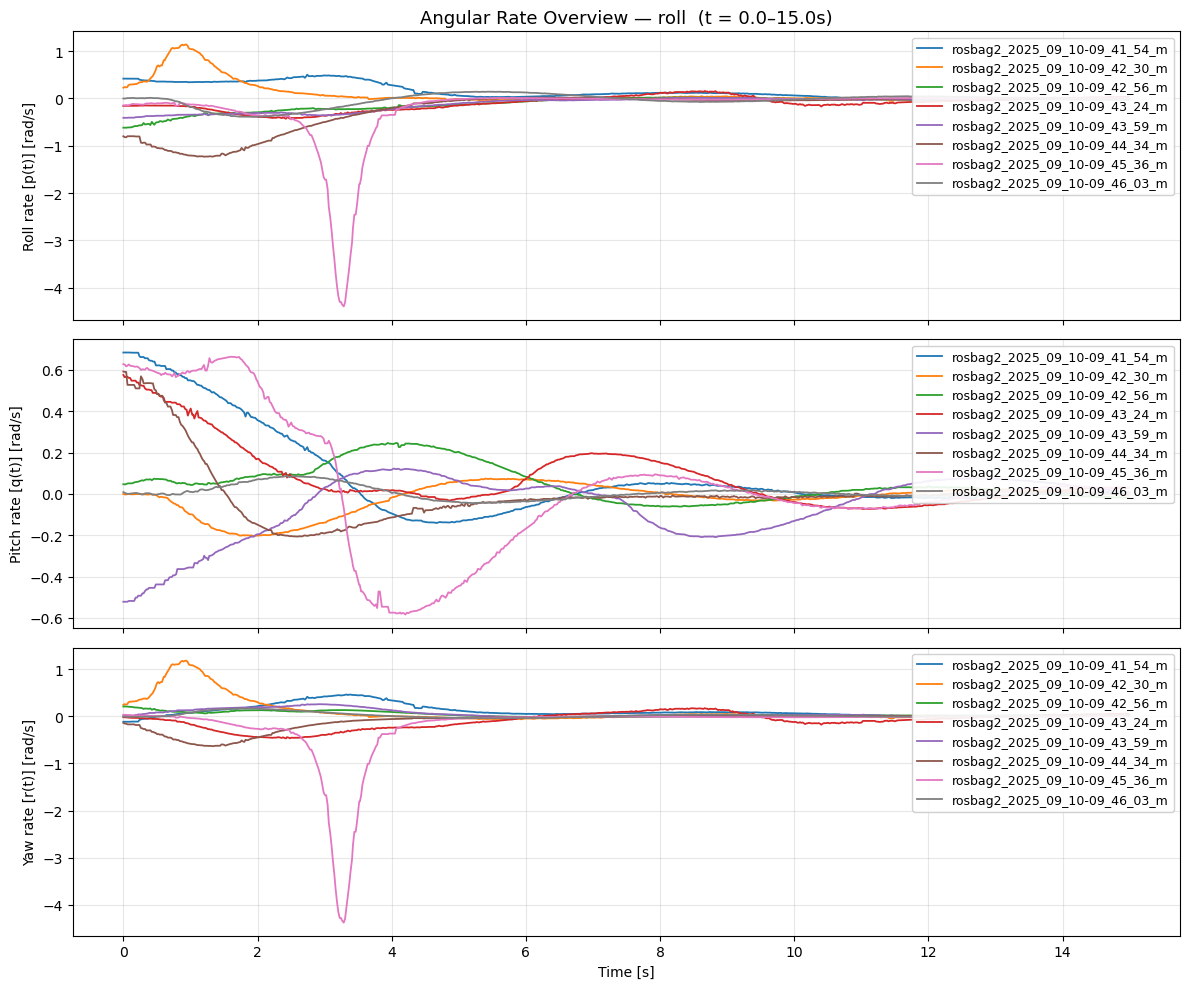

In [7]:
# ============================================================
# 🔍 Step 2 — Overview Plot of All Datasets (Roll, Pitch, Yaw Rate)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helper functions (same as before) ---
def find_time_column(df: pd.DataFrame) -> str:
    for cand in ["time_s", "t_s", "t", "sec", "seconds"]:
        if cand in df.columns:
            return cand
    raise ValueError("No time column found. Expected one of: time_s, t_s, t, sec, seconds.")

def pick_column(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def get_rate_rad_s(df: pd.DataFrame, axis: str, time_col: str) -> np.ndarray:
    axis = axis.lower()
    # 1️⃣ direct rad/s
    rate_rad_col = pick_column(df, [f"{axis}_rate_rad_s", f"gyro_{axis}_rad_s"])
    if rate_rad_col:
        return df[rate_rad_col].to_numpy(dtype=float)
    # 2️⃣ deg/s → rad/s
    rate_deg_col = pick_column(df, [f"{axis}_rate_deg_s", f"gyro_{axis}_deg_s", f"{axis}_deg_s"])
    if rate_deg_col:
        return np.deg2rad(df[rate_deg_col].to_numpy(dtype=float))
    # 3️⃣ derive from angles
    ang_rad_col = pick_column(df, [f"{axis}_rad", f"{axis}_angle_rad"])
    ang_deg_col = pick_column(df, [f"{axis}_deg", f"{axis}_angle_deg"])
    t = df[time_col].to_numpy(dtype=float)
    if ang_rad_col:
        ang = df[ang_rad_col].to_numpy(dtype=float)
        ang_unwrapped = np.unwrap(ang)
    elif ang_deg_col:
        ang_deg = df[ang_deg_col].to_numpy(dtype=float)
        ang_unwrapped = np.unwrap(np.deg2rad(ang_deg))
    else:
        raise ValueError(f"Missing rate/angle columns for '{axis}'.")
    dt = np.gradient(t)
    dy = np.gradient(ang_unwrapped)
    with np.errstate(divide="ignore", invalid="ignore"):
        w_rad_s = np.where(dt != 0.0, dy / dt, np.nan)
    return w_rad_s

# === Timeframe for all datasets ===
t_start = 0.0
t_end   = 15.0

# === Plot setup (3 subplots: roll, pitch, yaw) ===
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axes = axes.ravel()
axes_info = [
    ("roll",  "p", "Roll"),
    ("pitch", "q", "Pitch"),
    ("yaw",   "r", "Yaw")
]

# === Loop over each axis and plot all datasets ===
for ax, (axis_name, rate_symbol, axis_label) in zip(axes, axes_info):
    for name, df in datasets.items():
        try:
            time_col = find_time_column(df)
            t = df[time_col].to_numpy(dtype=float)
            t_s = t - t[0]
            w = get_rate_rad_s(df, axis_name, time_col)
            mask = (t_s >= t_start) & (t_s <= t_end)
            ax.plot(t_s[mask], w[mask], linewidth=1.3, label=f"{name}")
        except Exception as e:
            print(f"⚠️ Skipping {name} ({axis_name}): {e}")
    ax.set_ylabel(fr"{axis_label} rate [{rate_symbol}(t)] [rad/s]")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, framealpha=0.9, loc="upper right")

# === Titles & shared x-axis ===
axes[0].set_title(fr"Angular Rate Overview — {base_path.name}  (t = {t_start:.1f}–{t_end:.1f}s)", fontsize=13)
axes[-1].set_xlabel("Time [s]")
plt.tight_layout()
plt.show()


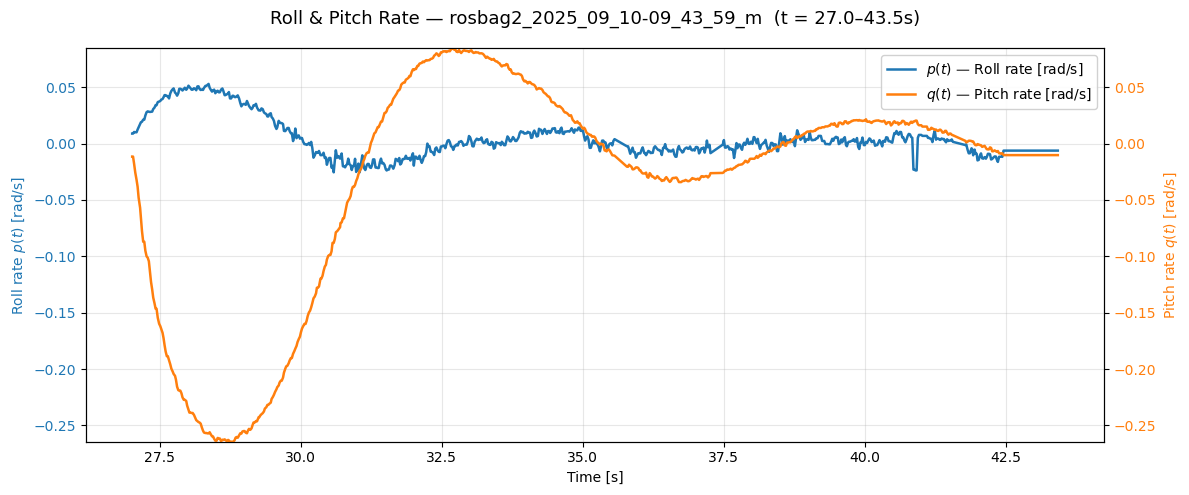

In [13]:
# ============================================================
# 🎯 Step 3 — Inspect Specific Dataset (Roll & Pitch Rate Together, Same Scale)
# ============================================================

selected_name = "rosbag2_2025_09_10-09_43_59_m"   # 👈 choose dataset name
t_start = 27
t_end   = 43.5

# === Validate dataset selection ===
if selected_name not in datasets:
    raise KeyError(f"Dataset '{selected_name}' not found. Available: {list(datasets.keys())}")

df_sel = datasets[selected_name]

# --- Find time column ---
time_col = find_time_column(df_sel)
t = df_sel[time_col].to_numpy(dtype=float)
t_s = t - t[0]

# --- Get roll and pitch rates (in rad/s) ---
w_roll  = get_rate_rad_s(df_sel, "roll", time_col)
w_pitch = get_rate_rad_s(df_sel, "pitch", time_col)

# --- Apply time window ---
mask = (t_s >= t_start) & (t_s <= t_end)
t_s = t_s[mask]
w_roll = w_roll[mask]
w_pitch = w_pitch[mask]

# --- Plot setup ---
fig, ax1 = plt.subplots(figsize=(12, 5))

color_roll = "tab:blue"
color_pitch = "tab:orange"

# --- Left axis: roll rate ---
ax1.plot(t_s, w_roll, color=color_roll, linewidth=1.8, label=r"$p(t)$ — Roll rate [rad/s]")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel(r"Roll rate $p(t)$ [rad/s]", color=color_roll)
ax1.tick_params(axis="y", labelcolor=color_roll)
ax1.grid(True, alpha=0.3)

# --- Right axis: pitch rate ---
ax2 = ax1.twinx()
ax2.plot(t_s, w_pitch, color=color_pitch, linewidth=1.8, label=r"$q(t)$ — Pitch rate [rad/s]")
ax2.set_ylabel(r"Pitch rate $q(t)$ [rad/s]", color=color_pitch)
ax2.tick_params(axis="y", labelcolor=color_pitch)

# --- 🔧 Synchronize y-axis limits ---
ymin = min(np.nanmin(w_roll), np.nanmin(w_pitch))
ymax = max(np.nanmax(w_roll), np.nanmax(w_pitch))
ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# --- Title & legends ---
fig.suptitle(fr"Roll & Pitch Rate — {selected_name}  (t = {t_start:.1f}–{t_end:.1f}s)", fontsize=13)

# combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()


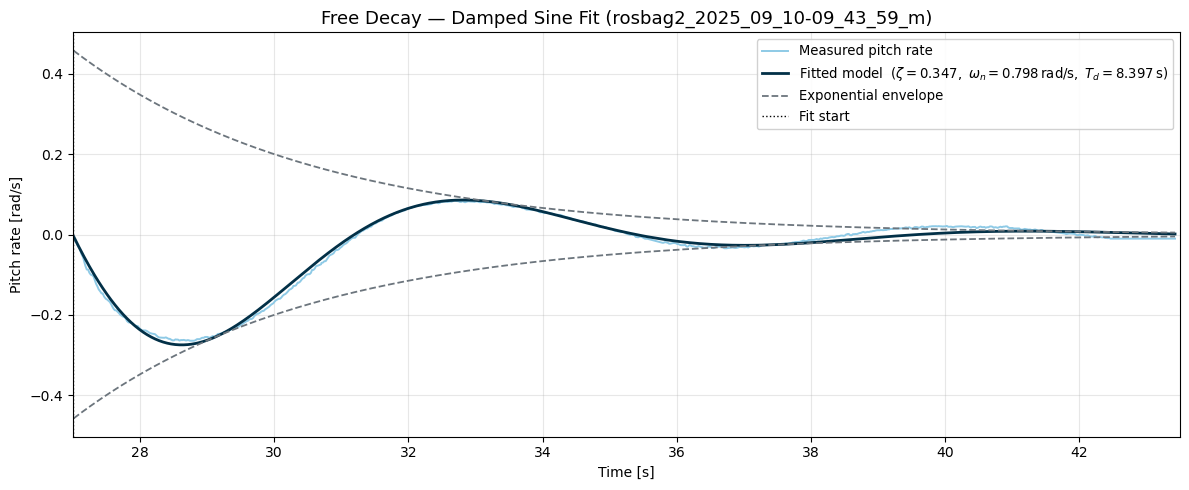


--- Fitted Parameters ---
A₀          = -0.4588 rad/s
ζ (zeta)    = 0.3470
ω_n         = 0.7979 rad/s
ω_d         = 0.7483 rad/s
T_d         = 8.3966 s
φ           = 0.0035 rad

--- Derived from Exponential Envelope ---
Logarithmic decrement δ = 2.3245
Time constant τ         = 3.6122 s
95% decay time t₉₅     ≈ 10.8367 s
Amplitude after 43.5s: -0.0000 rad/s  (from A₀=-0.4588)

Stored pitch fit: ζ = 0.3470, ωₙ = 0.7979 rad/s
[Excel] Wrote C:\Users\samue\Downloads\curvefit_rosbag2_2025_09_10-09_43_59_m_pitch_20251027-172219.xlsx (engine='openpyxl')


In [15]:
# ============================================================
# 🎯 Step 3l — Damped Sinusoid Fit + Envelope-Derived Parameters in Legend
# ============================================================

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# === Dataset & settings ===
AXIS = "pitch"
#t_start = 5.0           # 👈 visible and fitting start of data window
#t_end   = 20.0          # 👈 visible and fitting end of data window
DECAY_START_S = 27    # 👈 start of decay fit (within t_start–t_end)
DECAY_DURATION = 43.5   # [s] duration of fit

# --- Load dataset ---
df_sel = datasets[selected_name]
time_col = find_time_column(df_sel)
t = df_sel[time_col].to_numpy(dtype=float)
t_s = t - t[0]
w = get_rate_rad_s(df_sel, AXIS, time_col)

# --- Scope full dataset for visualization (t_start–t_end) ---
mask_vis = (t_s >= t_start) & (t_s <= t_end)
t_vis = t_s[mask_vis]
w_vis = w[mask_vis]

# --- Select fitting window (inside visible window) ---
mask_fit = (t_s >= DECAY_START_S) & (t_s <= DECAY_START_S + DECAY_DURATION)
t_fit = t_s[mask_fit]
w_fit = w[mask_fit]

# --- Define damped sinusoid model ---
def damped_sine(t, A, zeta, omega_n, phi):
    omega_d = omega_n * np.sqrt(1 - zeta**2)
    return A * np.exp(-zeta * omega_n * (t - DECAY_START_S)) * np.sin(omega_d * (t - DECAY_START_S) + phi)

# --- Initial guesses ---
A0 = np.max(np.abs(w_fit))
zeta0 = 0.1
omega_n0 = 2 * np.pi / 4   # assume ~4s period
phi0 = 0.0
p0 = [A0, zeta0, omega_n0, phi0]

# --- Fit ---
popt, _ = curve_fit(damped_sine, t_fit, w_fit, p0=p0, maxfev=50000)
A_fit, zeta_fit, omega_n_fit, phi_fit = popt

# --- Derived quantities ---
omega_d_fit = omega_n_fit * np.sqrt(1 - zeta_fit**2)
T_d_fit = 2 * np.pi / omega_d_fit
delta_fit = (2 * np.pi * zeta_fit) / np.sqrt(1 - zeta_fit**2)
tau_fit = 1 / (zeta_fit * omega_n_fit)
t95_fit = 3 * tau_fit
A_end = A_fit * np.exp(-zeta_fit * omega_n_fit * DECAY_DURATION)

# --- Compute fitted curve & envelopes ---
w_model = damped_sine(t_fit, *popt)
env_pos = A_fit * np.exp(-zeta_fit * omega_n_fit * (t_fit - DECAY_START_S))
env_neg = -env_pos

# ============================================================
# 🎨 Plot (Scoped to t_start–t_end)
# ============================================================
plt.figure(figsize=(12, 5))

# --- Colors ---
color_measured = "#8ecae6"   # light blue
color_fit = "#023047"        # dark blue
color_env = "#6c757d"        # gray

# --- Plot measured & fitted ---
plt.plot(t_vis, w_vis, color=color_measured, lw=1.4, label=f"Measured {AXIS} rate")
plt.plot(
    t_fit,
    w_model,
    color=color_fit,
    lw=2.0,
    label=fr"Fitted model  $(\zeta={zeta_fit:.3f},\ \omega_n={omega_n_fit:.3f}\,\mathrm{{rad/s}},\ T_d={T_d_fit:.3f}\,\mathrm{{s}})$"
)
plt.plot(t_fit, env_pos, color=color_env, lw=1.3, ls="--", label="Exponential envelope")
plt.plot(t_fit, env_neg, color=color_env, lw=1.3, ls="--")
plt.axvline(DECAY_START_S, color="k", ls=":", lw=1.0, label="Fit start")

# --- Axis limits ---
plt.xlim(t_start, t_end)

plt.xlabel("Time [s]")
plt.ylabel(f"{AXIS.capitalize()} rate [rad/s]")
plt.title(f"Free Decay — Damped Sine Fit ({selected_name})", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right", fontsize=9.5, framealpha=0.9)
plt.tight_layout()
plt.show()

# ============================================================
# 📊 Summary of Derived Quantities
# ============================================================
print("\n--- Fitted Parameters ---")
print(f"A₀          = {A_fit:.4f} rad/s")
print(f"ζ (zeta)    = {zeta_fit:.4f}")
print(f"ω_n         = {omega_n_fit:.4f} rad/s")
print(f"ω_d         = {omega_d_fit:.4f} rad/s")
print(f"T_d         = {T_d_fit:.4f} s")
print(f"φ           = {phi_fit:.4f} rad")

print("\n--- Derived from Exponential Envelope ---")
print(f"Logarithmic decrement δ = {delta_fit:.4f}")
print(f"Time constant τ         = {tau_fit:.4f} s")
print(f"95% decay time t₉₅     ≈ {t95_fit:.4f} s")
print(f"Amplitude after {DECAY_DURATION:.1f}s: {A_end:.4f} rad/s  (from A₀={A_fit:.4f})")

# ============================================================
# 💾 Store fitted results for later Fossen calculation
# ============================================================

from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import re

# (Keep storing the fitted parameters in case you use them later)
if AXIS.lower() == "roll":
    zeta_fit_roll = zeta_fit
    omega_n_fit_roll = omega_n_fit
    print(f"\nStored roll fit: ζ = {zeta_fit_roll:.4f}, ωₙ = {omega_n_fit_roll:.4f} rad/s")
elif AXIS.lower() == "pitch":
    zeta_fit_pitch = zeta_fit
    omega_n_fit_pitch = omega_n_fit
    print(f"\nStored pitch fit: ζ = {zeta_fit_pitch:.4f}, ωₙ = {omega_n_fit_pitch:.4f} rad/s")

# ---------- Helpers for robust export ----------
def _pick_excel_engine():
    for eng, pkg in (("openpyxl", "openpyxl"), ("xlsxwriter", "XlsxWriter")):
        try:
            __import__(pkg)
            return eng
        except ImportError:
            pass
    return None

def _slugify(s: str) -> str:
    return re.sub(r'[^A-Za-z0-9._-]+', '_', str(s)).strip('_')

def _infer_dataset_name():
    # Best effort: try common variables that might exist in your workspace
    loc = locals() | globals()
    candidates = [
        'selected_name', 'dataset_name', 'm', 'df_name',
        'file_path', 'source_path', 'infile', 'path', 'filename',
        'real', 'sim'
    ]
    for var in candidates:
        if var in loc:
            val = loc[var]
            if isinstance(val, (str, Path)):
                s = str(val)
                if any(s.lower().endswith(ext) for ext in ('.csv', '.xlsx', '.xls', '.parquet')):
                    try:
                        s = Path(s).stem
                    except Exception:
                        pass
                return _slugify(s)
    return "dataset"

def _get_angle_series(df, axis: str):
    """
    Try to find an angle column for the given axis ('roll' or 'pitch').
    Returns angle in radians (np.ndarray) or None if not found.
    """
    axis = axis.lower()
    if axis == "roll":
        cand = ["phi", "roll", "phi_rad", "roll_rad", "roll_angle"]
        cand_deg = ["phi_deg", "roll_deg"]
    else:  # pitch
        cand = ["theta", "pitch", "theta_rad", "pitch_rad", "pitch_angle"]
        cand_deg = ["theta_deg", "pitch_deg"]

    # rad candidates
    for c in cand:
        if c in df.columns:
            ang = df[c].to_numpy(dtype=float)
            # If values look like degrees (> ~pi*1.5), convert to rad
            if np.nanmax(np.abs(ang)) > np.pi * 1.5:
                ang = np.deg2rad(ang)
            return ang

    # deg candidates
    for c in cand_deg:
        if c in df.columns:
            return np.deg2rad(df[c].to_numpy(dtype=float))

    return None

# ---------- Build df_out with full-length signals ----------
# Always include time and angular rate used for the fit
df_out = pd.DataFrame({
    "time_s": t_s,
    "rate_radps": w
})

# If we can find an angle column for this axis, add a clean angle:
ang = _get_angle_series(df_sel, AXIS)
if ang is not None and len(ang) == len(t_s):
    ang = np.unwrap(ang)
    ang = ang - ang[0]  # zero at start for clarity
    df_out["angle_rad"] = ang
else:
    # Leave absent if not available; that's fine
    pass

# ---------- Write Excel (CSV fallback) ----------
out_dir = Path(r"C:\Users\samue\Downloads")
out_dir.mkdir(parents=True, exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
axis_tag = _slugify(AXIS.lower())
dataset_tag = _infer_dataset_name()
out_xlsx = out_dir / f"curvefit_{dataset_tag}_{axis_tag}_{stamp}.xlsx"

engine = _pick_excel_engine()
if engine:
    with pd.ExcelWriter(out_xlsx, engine=engine) as xw:
        df_out.to_excel(xw, index=False, sheet_name="signals")
    print(f"[Excel] Wrote {out_xlsx} (engine='{engine}')")
else:
    out_csv = out_xlsx.with_suffix(".csv")
    df_out.to_csv(out_csv, index=False)
    print(f"[CSV fallback] No Excel engine found. Wrote {out_csv}")
# =======================================================================



In [10]:
# ===============================================================
# === Calculate Fossen parameters: Kp, Mq, Kp_dot, Mq_dot (Free Decay) ===
# ===============================================================

import pandas as pd
import numpy as np

# === Known constants (from CAD & hydrostatics) ===
K_phi   = 4.34905    # [N·m/rad]  Roll restoring stiffness
K_theta = 4.63692    # [N·m/rad]  Pitch restoring stiffness
I_x     = 0.1231     # [kg·m²]    Roll inertia (from CAD)
I_y     = 0.1228     # [kg·m²]    Pitch inertia (from CAD)

# === Automatically pull available fit results ===
results = []

# --- Roll (φ) ---
if "zeta_fit_roll" in locals() and "omega_n_fit_roll" in locals():
    zeta_phi    = zeta_fit_roll
    omega_n_phi = omega_n_fit_roll

    I_x_star = K_phi / (omega_n_phi ** 2)          # apparent inertia
    Kp_dot   = I_x - I_x_star                      # added inertia
    Kp       = 2 * zeta_phi * omega_n_phi * I_x_star  # linear angular damping

    results.append({
        "Axis": "Roll (φ)",
        "ζ [-]": zeta_phi,
        "ω_n [rad/s]": omega_n_phi,
        "K [N·m/rad]": K_phi,
        "I [kg·m²]": I_x,
        "I* [kg·m²]": I_x_star,
        "Kp_dot [kg·m²]": Kp_dot,
        "Kp [N·m·s/rad]": Kp
    })

# --- Pitch (θ) ---
if "zeta_fit_pitch" in locals() and "omega_n_fit_pitch" in locals():
    zeta_theta    = zeta_fit_pitch
    omega_n_theta = omega_n_fit_pitch

    I_y_star = K_theta / (omega_n_theta ** 2)
    Mq_dot   = I_y - I_y_star
    Mq       = 2 * zeta_theta * omega_n_theta * I_y_star

    results.append({
        "Axis": "Pitch (θ)",
        "ζ [-]": zeta_theta,
        "ω_n [rad/s]": omega_n_theta,
        "K [N·m/rad]": K_theta,
        "I [kg·m²]": I_y,
        "I* [kg·m²]": I_y_star,
        "Mq_dot [kg·m²]": Mq_dot,
        "Mq [N·m·s/rad]": Mq
    })

# === Create and display results table ===
if results:
    df_fossen_main = pd.DataFrame(results)
    axes_list = ", ".join(df_fossen_main["Axis"].tolist())
    print(f"\n=== Fossen Hydrodynamic Coefficients ({axes_list}) ===")
    display(df_fossen_main.round(6))
else:
    print("⚠️ No fitted results found. Run the damped-sine fit first for roll and/or pitch.")



=== Fossen Hydrodynamic Coefficients (Pitch (θ)) ===


,Axis,ζ [-],ω_n [rad/s],K [N·m/rad],I [kg·m²],I* [kg·m²],Mq_dot [kg·m²],Mq [N·m·s/rad]
0,Pitch (θ),0.293323,0.983474,4.63692,0.1228,4.794066,-4.671266,2.765943
